In [1]:
import numpy as np
import pandas as pd
import warnings
import gc
import holidays

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBRegressor
from xgboost import plot_importance

warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-mar-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-mar-2022/train.csv
/kaggle/input/tabular-playground-series-mar-2022/test.csv


In [2]:
def evaluate_model(model, x, y):
    y_pred = model.predict(x)
    acc = mean_absolute_error(y, y_pred)
    return {'mae' : acc}

In [3]:
def preprocess_dates(df, date_column='time'):
    df = df.copy()
    df[date_column] = pd.to_datetime(df[date_column])
    df['weekday'] = df[date_column].dt.weekday
    df['quarter'] = df[date_column].dt.quarter
    df['day_of_year'] = df[date_column].dt.day_of_year
    df['is_month_start'] = df[date_column].dt.is_month_start.astype("int8")
    df['is_month_end'] = df[date_column].dt.is_month_end.astype("int8")
    df['month'] = df[date_column].dt.month
    return df

In [4]:
def preprocess_holidays(df, date_column='time'):
    holiday_us = holidays.CountryHoliday(country='US', years=[1991])
    dates = list(holiday_us.keys())
    dates = sorted(pd.to_datetime(dates))
    df = df.copy()
    df['is_holiday'] = df[date_column].apply(lambda x : 1 if x in dates else 0)
    return df

In [5]:
def preprocess_timeseries(df):
    df = df.copy()
    df['sin_day_of_year'] = np.sin(df['day_of_year'])
    df['sin_month'] = np.sin(df['month'])
    return df

In [6]:
seed = 47

# Reading the dataset

In [7]:
train_df = pd.read_csv("/kaggle/input/tabular-playground-series-mar-2022/train.csv", sep=',')

In [8]:
le = LabelEncoder()
train_df['direction'] = le.fit_transform(train_df['direction'])
train_df = preprocess_dates(train_df)
train_df = preprocess_holidays(train_df)
train_df = preprocess_timeseries(train_df)
x_train = train_df.drop(['row_id', 'time', 'congestion'], axis=1)
y_train = train_df['congestion']
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=seed, shuffle=False)

# XGBoost Baseline

In [9]:
def get_xgb_baseline(params={}):
    return XGBRegressor(**params,
                        random_state=seed,
                        tree_method='gpu_hist',
                        predictor='gpu_predictor',
                        objective='reg:linear',
                        verbosity=0)

In [10]:
model = get_xgb_baseline()
model.fit(x_train, y_train)
results = evaluate_model(model, x_test, y_test)
print(results)

{'mae': 8.499863220856414}


In [11]:
params = {'n_estimators': 200, 
          'max_depth': 23, 
          'subsample': 1.0,
          'eta': 0.3,
          'colsample_bytree': 1.0,
          'gamma': 0.0, 
          'min_child_weight': 1,
          'reg_alpha': 1
         }

model = get_xgb_baseline(params)
model.fit(x_train, y_train)
results = evaluate_model(model, x_test, y_test)
print(results)

{'mae': 8.513550744379739}


# Feature Engineering

In [12]:
geomean = lambda x, axis : np.exp(np.mean(np.log(x), axis=axis))
harmonic_mean = lambda x, axis : len(x) / np.sum(1.0/x, axis=axis) 

funcs = {'mean' : np.mean, 
         'std' : np.std, 
         'var' : np.var, 
         'geo_mean' : geomean, 
         'harmonic_mean' : harmonic_mean, 
         'median' : np.median,
         'none': None}

In [13]:
results, names = list(), list()

for key in funcs.keys():
    x_train = train_df.drop(['row_id', 'time', 'congestion'], axis=1).copy()
    y_train = train_df['congestion']
    if funcs[key] is not None:
        x_train[key] = funcs[key](x_train, axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=seed)       
    model = get_xgb_baseline()

    model.fit(x_train, y_train)
    result = evaluate_model(model, x_test, y_test)
    names.append(key)
    results.append(result['mae'])
    
for name, score in zip(names, results):
    print('>%s: %f' % (name, score))

index_best = np.argmin(results)
print('Best result is of:', names[index_best], 'with score:', results[index_best])

>mean: 8.081109
>std: 8.075240
>var: 8.075240
>geo_mean: 8.071936
>harmonic_mean: 8.071936
>median: 8.085318
>none: 8.071936
Best result is of: geo_mean with score: 8.071935973987891


# Individual parameter Search

In [14]:
x_train = train_df.drop(['row_id', 'time', 'congestion'], axis=1).copy()
x_train['geo_mean'] = geomean(x_train, axis=1)
y_train = train_df['congestion']
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=seed)

In [15]:
params = {}

# 1 - Testing different number of estimators

In [16]:
results_trees = {}
trees = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 950, 975, 1000, 1025, 1050, 1100, 1150, 1290, 1295, 1300, 1305, 1310, 1315, 1325, 2000, 3000, 4000, 5000, 10000]

for n in trees:
    params['n_estimators'] = n
    model = get_xgb_baseline(params)
    model.fit(x_train, y_train)
    result = evaluate_model(model, x_test, y_test)
    results_trees[n] = result['mae']
    print('n_estimators:', n, 'mae:', results_trees[n])

best_nestimator = min(results_trees, key=results_trees.get)
print('\nBest n_estimators:', best_nestimator, 'MAE score:', results_trees[best_nestimator])

n_estimators: 50 mae: 8.098969870575315
n_estimators: 100 mae: 8.071935973987891
n_estimators: 150 mae: 8.067395904870338
n_estimators: 200 mae: 8.065392368452843
n_estimators: 250 mae: 8.065226935161771
n_estimators: 300 mae: 8.067036818871536
n_estimators: 350 mae: 8.069107536655398
n_estimators: 400 mae: 8.070375316784153
n_estimators: 450 mae: 8.071097806215889
n_estimators: 500 mae: 8.072082348712842
n_estimators: 600 mae: 8.07440611479496
n_estimators: 700 mae: 8.076502485000626
n_estimators: 800 mae: 8.077473747664039
n_estimators: 900 mae: 8.07942300797621
n_estimators: 950 mae: 8.080230132845061
n_estimators: 975 mae: 8.080621999788361
n_estimators: 1000 mae: 8.081029068710457
n_estimators: 1025 mae: 8.081210106505747
n_estimators: 1050 mae: 8.081615174344801
n_estimators: 1100 mae: 8.082527706305083
n_estimators: 1150 mae: 8.083263353242629
n_estimators: 1290 mae: 8.085034841998688
n_estimators: 1295 mae: 8.085073193253486
n_estimators: 1300 mae: 8.085012052105336
n_estimator

# 2 - Testing different max_depth

In [17]:
results_max_depths = {}
params['n_estimators'] = best_nestimator
max_depths = [i for i in range(1,10)]

for max_depth in max_depths:
    params['max_depth'] = max_depth
    model = get_xgb_baseline(params)
    model.fit(x_train, y_train)
    result = evaluate_model(model, x_test, y_test)
    results_max_depths[max_depth] = result['mae']
    print('max_depth:', max_depth, 'mae:', results_max_depths[max_depth])

best_max_depth = min(results_max_depths, key=results_max_depths.get)
print('\nBest max_depth:', best_max_depth, 'MAE score:', results_max_depths[best_max_depth])


max_depth: 1 mae: 12.130907585709258
max_depth: 2 mae: 10.148481939536756
max_depth: 3 mae: 8.402857382666715
max_depth: 4 mae: 8.10713816683112
max_depth: 5 mae: 8.073201927660708
max_depth: 6 mae: 8.065226935161771
max_depth: 7 mae: 8.074449781435721
max_depth: 8 mae: 8.08971587449627
max_depth: 9 mae: 8.106609105961322

Best max_depth: 6 MAE score: 8.065226935161771


# 3 - Testing different subsamples

In [18]:
results_subsamples = {}
params['max_depth'] = best_max_depth
subsamples = [i for i in np.arange(0.1, 1.1, 0.1)]

for subsample in subsamples:
    params['subsample'] = subsample
    model = model = get_xgb_baseline(params)
    model.fit(x_train, y_train)
    result = evaluate_model(model, x_test, y_test)
    results_subsamples[subsample] = result['mae']
    print('subsample:', subsample, 'mae:', results_subsamples[subsample])

best_subsample = min(results_subsamples, key=results_subsamples.get)
print('\nBest subsample:', best_subsample, 'MAE score:', results_subsamples[best_subsample])

subsample: 0.1 mae: 8.167601738949482
subsample: 0.2 mae: 8.127354908028263
subsample: 0.30000000000000004 mae: 8.111676779891397
subsample: 0.4 mae: 8.098729444065379
subsample: 0.5 mae: 8.089593536277276
subsample: 0.6 mae: 8.08504783152857
subsample: 0.7000000000000001 mae: 8.084485460131148
subsample: 0.8 mae: 8.077101540448787
subsample: 0.9 mae: 8.071899320620203
subsample: 1.0 mae: 8.065226935161771

Best subsample: 1.0 MAE score: 8.065226935161771


# 4 - Testing different learning rates

In [19]:
results_etas = {}
params['subsample'] = best_subsample
etas = [0.0001, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.12, 0.13, 0.3, 0.5, 1.0]

for eta in etas:
    params['eta'] = eta
    model = get_xgb_baseline(params)
    model.fit(x_train, y_train)
    result = evaluate_model(model, x_test, y_test)
    results_etas[eta] = result['mae']
    print('eta:', eta, 'mae:', results_etas[eta])

best_eta = min(results_etas, key=results_etas.get)
print('\nBest eta:', best_eta, 'MAE score:', results_etas[best_eta])

eta: 0.0001 mae: 46.136625457536205
eta: 0.001 mae: 36.86965719472318
eta: 0.003 mae: 22.742519215118428
eta: 0.005 mae: 15.047991842870424
eta: 0.01 mae: 9.323195668526637
eta: 0.03 mae: 8.258023706939365
eta: 0.05 mae: 8.137329506261912
eta: 0.1 mae: 8.093808486980182
eta: 0.12 mae: 8.075397467035597
eta: 0.13 mae: 8.072615853462164
eta: 0.3 mae: 8.065226935161771
eta: 0.5 mae: 8.074846410531977
eta: 1.0 mae: 8.087375866200237

Best eta: 0.3 MAE score: 8.065226935161771


# 5 - Testing different number of features

In [20]:
results_colsample_bytrees = {}
params['eta'] = best_eta
colsample_bytrees = [i for i in np.arange(0.1, 1.1, 0.1)]

for colsample_bytree in colsample_bytrees:
    params['colsample_bytree'] = colsample_bytree
    model = get_xgb_baseline(params)
    model.fit(x_train, y_train)
    result = evaluate_model(model, x_test, y_test)
    results_colsample_bytrees[colsample_bytree] = result['mae']
    print('colsample_bytree:', colsample_bytree, 'mae:', results_colsample_bytrees[colsample_bytree])

best_colsample_bytree = min(results_colsample_bytrees, key=results_colsample_bytrees.get)
print('\nBest colsample_bytree:', best_colsample_bytree, 'MAE score:', results_colsample_bytrees[best_colsample_bytree])

colsample_bytree: 0.1 mae: 11.929616155170885
colsample_bytree: 0.2 mae: 10.098733113122089
colsample_bytree: 0.30000000000000004 mae: 9.685427240366547
colsample_bytree: 0.4 mae: 8.117423595464487
colsample_bytree: 0.5 mae: 8.071111212140918
colsample_bytree: 0.6 mae: 8.071760205744987
colsample_bytree: 0.7000000000000001 mae: 8.068274772448014
colsample_bytree: 0.8 mae: 8.067820531124957
colsample_bytree: 0.9 mae: 8.06764096511046
colsample_bytree: 1.0 mae: 8.065226935161771

Best colsample_bytree: 1.0 MAE score: 8.065226935161771


# 6 - Testing different values for min_child_weight

In [21]:
results_min_child_weight = {}
params['colsample_bytree'] = best_colsample_bytree
min_child_weights = [i for i in range(1,10)]

for min_child_weight in min_child_weights:
    params['min_child_weight'] = min_child_weight
    model = get_xgb_baseline(params)
    model.fit(x_train, y_train)
    result = evaluate_model(model, x_test, y_test)
    results_min_child_weight[min_child_weight] = result['mae']
    print('min_child_weight:', min_child_weight, 'mae:', results_min_child_weight[min_child_weight])

best_min_child_weight = min(results_min_child_weight, key=results_min_child_weight.get)
print('\nBest min_child_weight:', best_min_child_weight, 'MAE score:', results_min_child_weight[best_min_child_weight])

min_child_weight: 1 mae: 8.065226935161771
min_child_weight: 2 mae: 8.067403561257189
min_child_weight: 3 mae: 8.066030850601711
min_child_weight: 4 mae: 8.063262908781311
min_child_weight: 5 mae: 8.06533062434515
min_child_weight: 6 mae: 8.067016192093789
min_child_weight: 7 mae: 8.065577016539669
min_child_weight: 8 mae: 8.067062914961683
min_child_weight: 9 mae: 8.064423382761504

Best min_child_weight: 4 MAE score: 8.063262908781311


# 7 - Testing different values for gamma

In [22]:
results_gamma = {}
params['min_child_weight'] = best_min_child_weight
gammas = [0.01, 0.02, 0.03, 0.1, 0.3, 0.5, 1, 1.1, 1.5, 2, 5, 7, 9, 10]

for gamma in gammas:
    params['gamma'] = gamma
    model = get_xgb_baseline(params)
    model.fit(x_train, y_train)
    result = evaluate_model(model, x_test, y_test)
    results_gamma[gamma] = result['mae']
    print('gamma:', gamma, 'mae:', results_gamma[gamma])

best_gamma = min(results_gamma, key=results_gamma.get)
print('\nBest gamma:', best_gamma, 'Accuracy score:', results_gamma[best_gamma])

gamma: 0.01 mae: 8.06326272007663
gamma: 0.02 mae: 8.06326272007663
gamma: 0.03 mae: 8.06326272007663
gamma: 0.1 mae: 8.06607099146695
gamma: 0.3 mae: 8.065340618581443
gamma: 0.5 mae: 8.065455382693816
gamma: 1 mae: 8.06564621692029
gamma: 1.1 mae: 8.064451399176821
gamma: 1.5 mae: 8.067213955667166
gamma: 2 mae: 8.066028569624326
gamma: 5 mae: 8.06575350830032
gamma: 7 mae: 8.070040280357725
gamma: 9 mae: 8.07290777968284
gamma: 10 mae: 8.07329230095712

Best gamma: 0.01 Accuracy score: 8.06326272007663


In [23]:
params['gamma'] = best_gamma
print('Best Hyperparameters:', params)

Best Hyperparameters: {'n_estimators': 250, 'max_depth': 6, 'subsample': 1.0, 'eta': 0.3, 'colsample_bytree': 1.0, 'min_child_weight': 4, 'gamma': 0.01}


# Train model with the best found params

In [24]:
model = get_xgb_baseline(params)
model.fit(x_train, y_train)
result = evaluate_model(model, x_test, y_test)
print(result)

{'mae': 8.06326272007663}


<h2>Importance features plot</h2>

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

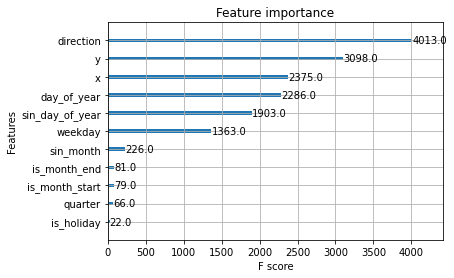

In [25]:
plot_importance(model)

# Submission

In [26]:
del train_df, x_train, y_train, x_test, y_test
gc.collect()

86

In [27]:
test_df = pd.read_csv("/kaggle/input/tabular-playground-series-mar-2022/test.csv", sep=',')

In [28]:
test_df['direction'] = le.transform(test_df['direction'])
test_df = preprocess_dates(test_df)
test_df = preprocess_holidays(test_df)
test_df = preprocess_timeseries(test_df)
x_test = test_df.drop(['row_id', 'time'], axis=1)
x_test['geo_mean'] = geomean(x_test, axis=1)

In [29]:
target = model.predict(x_test).squeeze()
row_id =  test_df['row_id'].values
submission = pd.DataFrame({'row_id' : row_id, 'congestion' : target})

In [30]:
submission.head()

,row_id,congestion
0,848835,44.335278
1,848836,30.653568
2,848837,51.141079
3,848838,25.126944
4,848839,62.676308


In [31]:
submission.to_csv('submission.csv', index=False)